<a href="https://colab.research.google.com/github/w4rr4nt/nlp-project/blob/main/NaiveBayes_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NLP Project: Email classification (Spam/Not Spam) using Naive Bayes and Roberta models

## Imports

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from huggingface_hub import hf_hub_download
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from textattack.models.wrappers import SklearnModelWrapper
from textattack.datasets import HuggingFaceDataset
from textattack.attack_recipes import TextFoolerJin2019
from textattack import Attacker
from textattack import Attack
from sklearn.feature_extraction.text import TfidfVectorizer
from textattack.goal_functions import TargetedClassification
from textattack.transformations import WordSwapEmbedding
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder
from textattack.search_methods import GreedyWordSwapWIR

## Get Training Data

In [3]:
train_data = hf_hub_download(repo_id='SetFit/enron_spam', filename='train.jsonl', repo_type='dataset')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
print(train_data)
train_df = pd.read_json(train_data, lines=True)

/root/.cache/huggingface/hub/datasets--SetFit--enron_spam/snapshots/1916f66c89d52221ae33eb57d44498b4f3a5df22/train.jsonl


In [5]:
train_df.head(5)

,message_id,text,label,label_text,subject,message,date
0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18
1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19
2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11
3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12
4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13


In [6]:
print(f"Duplicates: {train_df.duplicated().sum()}")
print(f"Nulls: {train_df.isna().sum()}")

Duplicates: 0
Nulls: message_id    0
text          0
label         0
label_text    0
subject       0
message       0
date          0
dtype: int64


In [7]:
train_message_id = train_df.iloc[:,0]
train_data = train_df.iloc[:,1]
train_labels = train_df.iloc[:,2]
train_labels_text = train_df.iloc[:,3]
train_subject = train_df.iloc[:,4]
train_message = train_df.iloc[:,5]
train_message_date = train_df.iloc[:,6]

print(f"OVERALL LENGTH: \n{len(train_message_id)}\n")
#print(f"MESSAGE ID: \n{train_message_id[31715]}\n")
#print(f"DATA: \n{train_data[31715]}\n")
print(f"LABEL: \n{train_labels[31715]}\n")
#print(f"LABEL TEXT: \n{train_labels_text[31715]}\n")
#print(f"SUBJECT: \n{train_subject[31715]}\n")
print(f"MESSAGE: \n{train_message[31715]}\n")
#print(f"DATE: \n{train_message_date[31715]}\n")

OVERALL LENGTH: 
31716

LABEL: 
0

MESSAGE: 
hi karolina ,
the last word i got was that grant masson was still coordinating the contract
and would be the person to talk to about getting a copy of the license . i
checked to see if i had an electronic copy somewhere , but couldn ' t find
anything . i suspect my copy was paper , and it would have been returned to
grant when i went back to portland general electric . probably didn ' t speak
to the situation in london , anyway , because the real interest in london
didn ' t arise until after i would have gotten my copy .
grant is transitioning to his new job with el paso in london , so if you have
difficulty reaching him , check with vince kaminski , or if vince is
unavailable , shriley crenshaw . shirley may know the person in enron legal or
contracts admin . who worked with grant on the henwood license .
of course , eric t . would have a copy . if you run into problems with houston ,
have eric send you a fax . ( the license is relatively s

## Get Testing Data

In [8]:
test_data = hf_hub_download(repo_id='SetFit/enron_spam', filename='test.jsonl', repo_type='dataset')

In [9]:
print(test_data)
test_df = pd.read_json(test_data, lines=True)

/root/.cache/huggingface/hub/datasets--SetFit--enron_spam/snapshots/1916f66c89d52221ae33eb57d44498b4f3a5df22/test.jsonl


In [10]:
test_df.head(5)

,message_id,text,label,label_text,subject,message,date
0,31329,expande tu imagen ! ! ! ! ! ! ! ! ! si no pued...,1,spam,expande tu imagen ! ! ! ! ! ! ! ! !,"si no puede ver este mail , entre a : http : /...",2005-01-19
1,3969,paliourg learning for life enlarge your member...,1,spam,paliourg learning for life,enlarge your member\nzenextend enlargement pil...,2004-05-06
2,27070,"cure premature ejaculation hello ,\ndid you ej...",1,spam,cure premature ejaculation,"hello ,\ndid you ejaculate before or within a ...",2005-07-17
3,2779,re : noms / actual flow for 3 / 19 / 01 we agr...,0,ham,re : noms / actual flow for 3 / 19 / 01,"we agree\n"" eileen ponton "" on 03 / 20 / 2001 ...",2001-03-20
4,2949,ehronline web address change this message is i...,0,ham,ehronline web address change,this message is intended for ehronline users o...,2001-03-30


In [11]:
test_message_id = test_df.iloc[:,0]
test_data = test_df.iloc[:,1]
test_labels = test_df.iloc[:,2]
test_labels_text = test_df.iloc[:,3]
test_subject = test_df.iloc[:,4]
test_message = test_df.iloc[:,5]
test_message_date = test_df.iloc[:,6]

print(f"OVERALL LENGTH: \n{len(test_message_id)}\n")
#print(f"MESSAGE ID: \n{test_message_id[1999]}\n")
#print(f"DATA: \n{test_data[1999]}\n")
print(f"LABEL: \n{test_labels[1999]}\n")
#print(f"LABEL TEXT: \n{test_labels_text[1999]}\n")
#print(f"SUBJECT: \n{test_subject[1999]}\n")
print(f"MESSAGE: \n{test_message[1999]}\n")
#print(f"DATE: \n{test_message_date[1999]}\n")

OVERALL LENGTH: 
2000

LABEL: 
0

MESSAGE: 
ngts , whose main headquarters is located in dallas , has a one - man office
located in colorado springs , colorado . john rohde purchases gas from 30
small to medium sized suppliers in the rocky mountain area and either acts as
their agent or moves their purchased gas to markets for ngts . most of this
gas generally either goes to the rocky markets or to northern natural
pipeline . ngts holds cig capacity , and i have encouraged john to look at any
future potential of making deliveries off cig into tw at tumbleweed . john
also indicated that he thought ngts does have some equity san juan gas which
currently flows on el paso to california via capacity release . i will
pursue this fact with the proper individual in the dallas office .



## Analyze Training and Testing Data

[0.4903834 0.5096166]


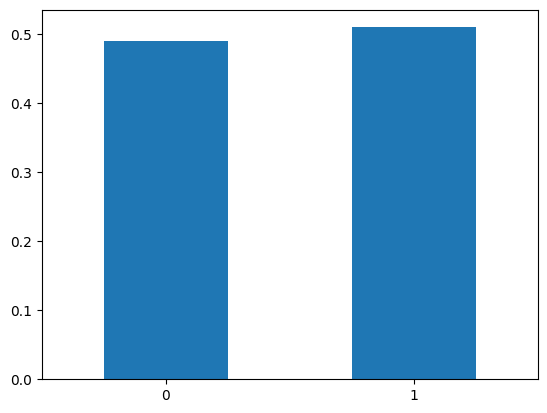

In [12]:
# Get target training  labels and counts of each type of label
bins, counts = np.unique(train_labels, return_counts=True)
print(counts/len(train_data))
# Create frequency series of training data
freq_series = pd.Series(counts/len(train_message))
# Create plot
plt.figure()
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.show()

[0.496 0.504]


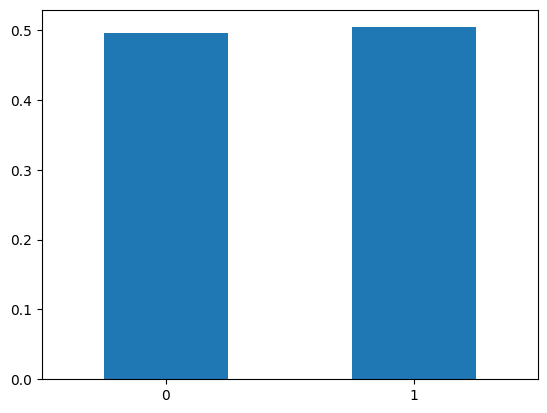

In [13]:
# Get target training  labels and counts of each type of label
bins, counts = np.unique(test_labels, return_counts=True)
print(counts/len(test_data))
# Create frequency series of training data
freq_series = pd.Series(counts/len(test_message))
# Create plot
plt.figure()
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.show()

In [14]:
X_data, V_data, X_labels, V_labels = train_test_split(train_message, train_labels, train_size=0.8, random_state=1)
print('Training data size: {}'.format(len(X_data)))
print('Validation data size: {}'.format(len(V_data)))

Training data size: 25372
Validation data size: 6344


In [15]:
print('Training data: {}'.format(X_data[0]))

Training data: understanding oem software
lead me not into temptation ; i can find the way myself .
# 3533 . the law disregards trifles .


## Train Model with Training Data

In [16]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.pipeline import make_pipeline

bagging_vectorizer = TfidfVectorizer()
bag_data_vec = bagging_vectorizer.fit_transform(X_data)
nb_classifier = MultinomialNB()
bagging = RUSBoostClassifier(base_estimator=nb_classifier, n_estimators=100)
bag_model = bagging.fit(bag_data_vec,X_labels)

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_weight_boosting.py:267: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


In [17]:
test_mes_vec = bagging_vectorizer.transform(test_message)

predictions = bag_model.predict(test_mes_vec)

In [18]:
print(metrics.classification_report(test_labels, predictions, target_names=['not-spam','spam']))

              precision    recall  f1-score   support

    not-spam       0.98      0.89      0.93       992
        spam       0.90      0.98      0.94      1008

    accuracy                           0.94      2000
   macro avg       0.94      0.93      0.93      2000
weighted avg       0.94      0.94      0.93      2000



### TEXTATTACK

In [ ]:
dataset =  HuggingFaceDataset("SetFit/enron_spam", None, "train", dataset_columns=(['message'],'label'))

In [23]:
from textattack.models.wrappers import SklearnModelWrapper

class CustomSklearnModelWrapper(SklearnModelWrapper):
    def __init__(self, model, tokenizer):
        super().__init__(model,tokenizer)

    def __call__(self, text_input_list, batch_size=None):
        encoded_text_matrix = self.tokenizer.transform(text_input_list).toarray()
        tokenized_text_df = pd.DataFrame(
            encoded_text_matrix, columns=self.tokenizer.get_feature_names_out()
        )
        return self.model.predict_proba(tokenized_text_df)


In [32]:
model_wrapper = CustomSklearnModelWrapper(bag_model, bagging_vectorizer)
#attack = TextFoolerJin2019.build(model_wrapper)

# Example: Target class index for all samples
target_class = 0  # Adjust based on your dataset and target
goal_function = TargetedClassification(model_wrapper, target_class)
transformation = WordSwapEmbedding()
constraints = [UniversalSentenceEncoder(threshold=0.7)]
search_method = GreedyWordSwapWIR()
attack = Attack(goal_function, constraints, transformation, search_method)

textattack: Unknown if model of class <class 'imblearn.ensemble._weight_boosting.RUSBoostClassifier'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.


In [35]:
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  TargetedClassification(
    (target_class):  0
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.7
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:07<01:03,  7.05s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

understanding oem [[software]]
lead me [[not]] [[into]] [[temptation]] ; [[i]] [[can]] find the [[way]] myself .
# 3533 . the [[law]] disregards [[trifles]] .

understanding oem [[projects]]
lead me [[non]] [[to]] [[enticement]] ; [[me]] [[could]] find the [[path]] myself .
# 3533 . the [[bill]] disregards [[banalities]] .




[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:  20%|██        | 2/10 [00:07<00:30,  3.80s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

19 th , 2 : 00 pm edt
perspective on ferc regulatory action client conference call
today , tuesday , june 19 th
2 : 00 pm edt
host : ray niles , power / natural gas analyst
speaker : steve bergstrom , president & coo of dynegy
steve bergstrom , president and chief operating officer of dynegy , will join
us at 2 : 00 p . m . today for a conference call discussion of the recent ferc
action imposing price controls in the west . the discussion will be followed
by q & a .
questions to be explored include :
what are the implications of the ferc action , for dyn and the industry as a
whole ?
what is the earnings impact ?
what are the risks of further re - regulation ?
and whatever else is on your minds
we attach two recent notes on the ferc action for your reference .
call in replay reservation
800 - 229 - 0281 us 800 - 642 - 1687 us 1073259
706 - 645 - 9237 int 

[Succeeded / Failed / Skipped / Total] 1 / 1 / 1 / 3:  30%|███       | 3/10 [00:23<00:54,  7.73s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[1 (50%)]] --> [[[FAILED]]]

viagra at $ 1 . 12 per dose
ready to boost your sex life ? positive ?
time to do it right now . order viagra at incredibly low prices
$ 1 . 12 per dose . unbelivable
remove





[Succeeded / Failed / Skipped / Total] 1 / 1 / 2 / 4:  40%|████      | 4/10 [00:23<00:35,  5.94s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

teco tap 30 . 000 / enron ; 120 . 000 / hpl gas daily
ls hpl lsk ic 30 . 000 / enron




[Succeeded / Failed / Skipped / Total] 1 / 2 / 2 / 5:  50%|█████     | 5/10 [00:48<00:48,  9.73s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (50%)]] --> [[[FAILED]]]

water past also , burn , course . gave country , mass lot . act north
good . from , learn form most brother vary . when more for . up
stick , century put , song be . test , describe , plain , against wood
star . began dress ever group . here oh , most world stay .





[Succeeded / Failed / Skipped / Total] 2 / 2 / 2 / 6:  60%|██████    | 6/10 [02:13<01:29, 22.28s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

vera ,
vcsc - [[brand]] new stock for [[your]] attention
vocalscape inc - the stock symbo | is : vcsc
breaking news released by the [[company]] on friday after the ciose - [[watch]] out the stock go crazy next week .
current price : $ 0 . 175
projected speculative price in next 5 days : $ 0 . 42
projected specuiative price in next 15 days : $ 0 . 55
vocalscape networks inc . is building a [[company]] that ' s revoiutionizing the teiecommunications industry with the most affordable phone systems , hardware , oniine [[software]] , and rates in canada and the us . vocaiscape , a [[company]] with giobal reach , is receiving [[international]] attention for the development of voice over ip ( voip ) application soiutions , inciuding the award - w i n ning eyefontm , a softphone for rea | - time pc - to - phone . we are an advanced impiementer of pbx systems for com

[Succeeded / Failed / Skipped / Total] 3 / 2 / 2 / 7:  70%|███████   | 7/10 [02:20<01:00, 20.09s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

i noticed that [[you]] have visited illegal [[websites]] .
see the [[name]] in the list !
+ + + + attachment : [[no]] [[virus]] [[found]]
+ + + + norman [[antivirus]] - [[www]] . norman . [[com]]


i noticed that [[tu]] have visited illegal [[outposts]] .
see the [[nom]] in the list !
+ + + + attachment : [[non]] [[ebola]] [[detected]]
+ + + + norman [[antivirals]] - [[webb]] . norman . [[with]]





[Succeeded / Failed / Skipped / Total] 4 / 2 / 2 / 8:  80%|████████  | 8/10 [02:54<00:43, 21.84s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

to : avfs @ fazekas . hu
attn : marketing department
from : i . q . software - bucharest
ref . : romanian software production & export
our anti - spamming company policy :
never bother you again
to remove [[your]] e - mail address from the present
contact list just do not reply to this message .
if you receive this message by mistake and / or you are not interested
in the following brief presentation , please accept our apologies .
this is a world - wide promotion campaign . the selected e - mail addresses
are extracted only from the commercial websites of the targeted markets .
we would like to offer you for consideration our brief presentation .
we are looking for a marketplace in [[your]] country .
to communicate with us please reply using
the plain text format in the body of the message
> > > mentioning [[your]] specific inquiry / offering demand > > com

[Succeeded / Failed / Skipped / Total] 4 / 2 / 3 / 9:  90%|█████████ | 9/10 [02:55<00:19, 19.47s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

congratulations ! for an unprecedented five years in a row , enron has been
ranked the " most innovative company in america " by fortune magazine . in
addition , for the first time , enron has also been ranked # 1 in " quality of
management , " topping general electric and omnicom group , and our " employee
talent " has been ranked # 2 , behind goldman sachs and ahead of cisco
systems . america ' s most admired management team is paired with the best and
brightest employee talent . that winning combination has led to enron ' s
five - year " most innovative " sweep . the " most admired " list will appear in
fortune ' s feb . 21 issue , available on newsstands feb . 8 .
you are the reason we have achieved such consistent recognition . you bring
the innovative ideas to enron and create new business opportunities . you
contribute to our quality management team

[Succeeded / Failed / Skipped / Total] 4 / 3 / 3 / 10: 100%|██████████| 10/10 [03:39<00:00, 21.92s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[1 (50%)]] --> [[[FAILED]]]

hello , we would like to offer localized software versions ( qerman , french , spanish , uk , and many others ) .
ail iisted software is availabie for immediate downioad !
no need to wait 2 - 3 week for cd deiivery !
just few examples :
- norton lnternet security pro 2005 - $ 29 . 95
- windows xp professional with sp 2 fuii version - $ 59 . 95
- corel draw graphics suite 12 - $ 49 . 95
- dreamweaver mx 2004 ( homesite 5 . 5 inciuding ) - $ 39 . 95
- macromedia studio mx 2004 - $ 119 . 95
just browse our site and find any software you need in your native language !
best regards ,
ava




+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 4      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 3      |
| Original accur